In [192]:
import numpy as np 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud
import re
import string

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
!pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [193]:
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [70]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

File ‘AirlineTweets.csv’ already there; not retrieving.



In [194]:
df = pd.read_csv("AirlineTweets.csv", encoding="ISO-8859-1")

In [195]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [196]:
labels = df["airline_sentiment"].astype("category").cat.codes
inputs = df["text"]

In [197]:
inputs

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [198]:
def cleaner(impure_data):
    temp_list = []
    for item in impure_data:
        #finding words which start with @
        item = re.sub('@\S+', '', item)
        #finding words which start with http
        item = re.sub('http\S+\s*', '', item)
        temp_list.append(item)
    return temp_list

In [199]:
inputs = cleaner(inputs)
inputs

[' What  said.',
 " plus you've added commercials to the experience... tacky.",
 " I didn't today... Must mean I need to take another trip!",
 ' it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 " and it's a really big bad thing about it",
 " seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA",
 ' yes, nearly every time I fly VX this â\x80\x9cear wormâ\x80\x9d wonâ\x80\x99t go away :)',
 ' Really missed a prime opportunity for Men Without Hats parody, there. ',
 " Well, I didn'tâ\x80¦but NOW I DO! :-D",
 " it was amazing, and arrived an hour early. You're too good to me.",
 ' did you know that suicide is the second leading cause of death among teens 10-24',
 ' I &lt;3 pretty graphics. so much better than minimal iconography. :D',
 " This is such a great deal! Already thinking about my 2nd trip to  &amp; I haven't even gone on my 1st trip yet! ;p",
 "

In [200]:
labels

0        1
1        2
2        1
3        0
4        0
        ..
14635    2
14636    0
14637    1
14638    0
14639    1
Length: 14640, dtype: int8

In [201]:
train_x, test_x, train_y, test_y = train_test_split(inputs, labels, test_size=0.33)

In [202]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
    self.stopwords = set(stopwords.words("english"))
  def __call__(self, doc):
    doc = doc.rstrip().lower()
    if doc:
      doc = doc.translate(str.maketrans('', '', string.punctuation))
      tokens = word_tokenize(doc)
      words_and_tags = nltk.pos_tag(tokens)
      tokens = [t for t in tokens if len(t) > 2]
      tokens = [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in words_and_tags]
      tokens = [t for t in tokens if t not in self.stopwords]
      tokens = [t for t in tokens if not any(c.isdigit() for c in t)]
      return tokens

In [203]:
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer())
Xtrain = vectorizer.fit_transform(train_x)
Xtest = vectorizer.transform(test_x)

In [204]:
D = Xtrain.shape[1]
Xtrain = Xtrain.toarray()
Xtest = Xtest.toarray()

In [207]:
K = max(labels) + 1
K

3

In [208]:
i = Input(shape=(D,))
x = Dense(300, activation="elu")(i)
x = Dense(150, activation="elu")(x)
x = Dense(100, activation="elu")(x)
x = Dense(K)(x)

model = Model(i, x)

In [209]:
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 8654)]            0         
                                                                 
 dense_38 (Dense)            (None, 300)               2596500   
                                                                 
 dense_39 (Dense)            (None, 150)               45150     
                                                                 
 dense_40 (Dense)            (None, 100)               15100     
                                                                 
 dense_41 (Dense)            (None, 3)                 303       
                                                                 
Total params: 2,657,053
Trainable params: 2,657,053
Non-trainable params: 0
_________________________________________________________________


In [210]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

ft = model.fit( 
    Xtrain, train_y,
    validation_data=(Xtest, test_y),
    epochs=40,
    batch_size=128
)

Epoch 1/40
77/77 [==============================] - 6s 75ms/step - loss: 0.9371 - accuracy: 0.6099 - val_loss: 0.7863 - val_accuracy: 0.6393
Epoch 2/40
77/77 [==============================] - 4s 50ms/step - loss: 0.7041 - accuracy: 0.6778 - val_loss: 0.6272 - val_accuracy: 0.7486
Epoch 3/40
77/77 [==============================] - 5s 65ms/step - loss: 0.5075 - accuracy: 0.8254 - val_loss: 0.5541 - val_accuracy: 0.7806
Epoch 4/40
77/77 [==============================] - 4s 54ms/step - loss: 0.3777 - accuracy: 0.8779 - val_loss: 0.5497 - val_accuracy: 0.7792
Epoch 5/40
77/77 [==============================] - 4s 50ms/step - loss: 0.2961 - accuracy: 0.9044 - val_loss: 0.5795 - val_accuracy: 0.7748
Epoch 6/40
77/77 [==============================] - 4s 50ms/step - loss: 0.2413 - accuracy: 0.9232 - val_loss: 0.6242 - val_accuracy: 0.7697
Epoch 7/40
77/77 [==============================] - 4s 50ms/step - loss: 0.2035 - accuracy: 0.9367 - val_loss: 0.6737 - val_accuracy: 0.7635
Epoch 8/40
77

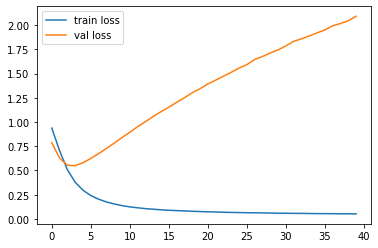

In [211]:
plt.plot(ft.history["loss"], label="train loss")
plt.plot(ft.history["val_loss"], label="val loss")
plt.legend();

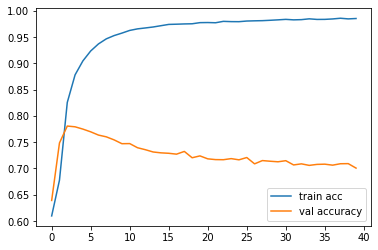

In [212]:
plt.plot(ft.history["accuracy"], label="train acc")
plt.plot(ft.history["val_accuracy"], label="val accuracy")
plt.legend();

In [217]:
Ptrain = np.argmax(model.predict(Xtrain), axis=1)
Ptest = np.argmax(model.predict(Xtest), axis=1)

151/151 [==============================] - 1s 8ms/step


In [219]:
print(Ptrain)
cm = confusion_matrix(train_y, Ptrain)
cm

[1 0 1 ... 1 0 2]


array([[6051,   44,    1],
       [  20, 2047,   28],
       [   1,   20, 1596]])

In [220]:
cm_test = confusion_matrix(test_y, Ptest, normalize="true")
cm_test

array([[0.80337443, 0.14763141, 0.04899416],
       [0.37051793, 0.50298805, 0.12649402],
       [0.2386059 , 0.21849866, 0.54289544]])

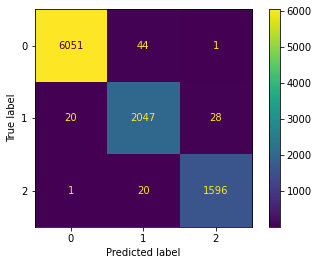

In [222]:
ConfusionMatrixDisplay.from_predictions(train_y, Ptrain);

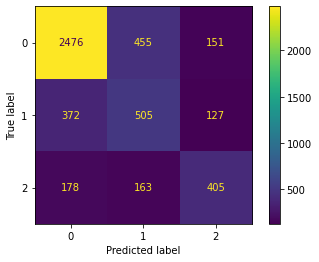

In [224]:
ConfusionMatrixDisplay.from_predictions(test_y, Ptest);